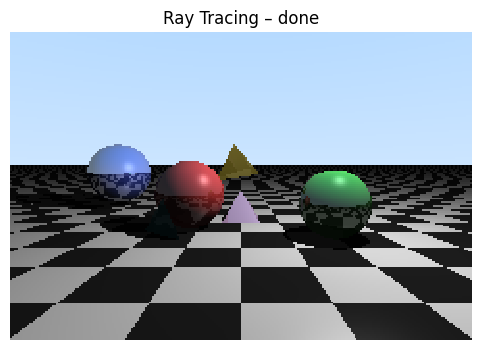

In [7]:
# Ray Tracing Demo — Single-Figure, Live Updating (Jupyter/Colab safe)
# Scene: checkerboard plane + spheres + triangles (Möller–Trumbore)

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from IPython.display import display

# ------------ Settings ------------
WIDTH, HEIGHT = 240,160       # Image resolution
FOV_DEG = 60.0                 # Field of view (degrees)
MAX_DEPTH = 3                  # Max reflection depth
SAMPLES_PER_PIXEL = 1          # Keep 1 for "live" updates; increase for quality
UPDATE_EVERY_N_ROWS = 1        # UI refresh stride

# ------------ Math helpers ------------
def norm(v):
    n = np.linalg.norm(v)
    return v / n if n > 0 else v

def reflect(v, n):
    return v - 2.0*np.dot(v, n)*n

# ------------ Materials ------------
@dataclass
class Material:
    color: np.ndarray
    ambient: float = 0.05
    diffuse: float = 0.9
    specular: float = 0.4
    shininess: float = 64.0
    reflectivity: float = 0.0

# ------------ Geometry: Sphere ------------
@dataclass
class Sphere:
    center: np.ndarray
    radius: float
    material: Material

    def intersect(self, ro, rd):
        oc = ro - self.center
        b = 2.0 * np.dot(oc, rd)
        c = np.dot(oc, oc) - self.radius*self.radius
        disc = b*b - 4.0*c
        if disc < 0.0:
            return None
        s = np.sqrt(disc)
        t1 = (-b - s) / 2.0
        t2 = (-b + s) / 2.0
        t = 1e9
        if t1 > 1e-4: t = min(t, t1)
        if t2 > 1e-4: t = min(t, t2)
        return t if t < 1e8 else None

    def normal_at(self, p):
        return norm(p - self.center)

# ------------ Geometry: Infinite Checker Plane ------------
@dataclass
class Plane:
    normal: np.ndarray
    d: float
    material_a: Material
    material_b: Material
    checker_size: float = 1.0

    def intersect(self, ro, rd):
        denom = np.dot(self.normal, rd)
        if abs(denom) < 1e-6:
            return None
        t = -(np.dot(self.normal, ro) + self.d) / denom
        return t if t > 1e-4 else None

    def normal_at(self, p):
        return self.normal

    def material_at(self, p):
        u = np.floor(p[0] / self.checker_size)
        v = np.floor(p[2] / self.checker_size)
        return self.material_a if (int(u + v) % 2 == 0) else self.material_b

# ------------ Geometry: Triangle (Möller–Trumbore) ------------
@dataclass
class Triangle:
    v0: np.ndarray
    v1: np.ndarray
    v2: np.ndarray
    material: Material

    def intersect(self, ro, rd):
        EPS = 1e-6
        e1 = self.v1 - self.v0
        e2 = self.v2 - self.v0
        pvec = np.cross(rd, e2)
        det  = np.dot(e1, pvec)
        # Backface culling OFF (double-sided). For one-sided, use: if det < EPS: return None
        if abs(det) < EPS:
            return None
        inv_det = 1.0 / det
        tvec = ro - self.v0
        u = np.dot(tvec, pvec) * inv_det
        if u < 0.0 or u > 1.0:
            return None
        qvec = np.cross(tvec, e1)
        v = np.dot(rd, qvec) * inv_det
        if v < 0.0 or (u + v) > 1.0:
            return None
        t = np.dot(e2, qvec) * inv_det
        return t if t > EPS else None

    def normal_at(self, p):
        n = np.cross(self.v1 - self.v0, self.v2 - self.v0)
        nrm = np.linalg.norm(n)
        return n / nrm if nrm > 0 else np.array([0.0, 1.0, 0.0])

def make_triangles_from_mesh(verts, faces, material):
    """
    verts: (N,3) list/array
    faces: (M,3) list/array of vertex indices
    """
    verts = np.asarray(verts, dtype=float)
    tris = []
    for (i, j, k) in faces:
        tris.append(Triangle(verts[i], verts[j], verts[k], material))
    return tris

# ------------ Scene ------------
white = Material(np.array([1.0, 1.0, 1.0]), reflectivity=0.0)
black = Material(np.array([0.07, 0.07, 0.07]), reflectivity=0.0)
red   = Material(np.array([0.95, 0.25, 0.25]), reflectivity=0.15)
green = Material(np.array([0.25, 0.95, 0.25]), reflectivity=0.25)
blue  = Material(np.array([0.25, 0.35, 0.95]), reflectivity=0.5)

plane = Plane(
    normal=np.array([0.0, 1.0, 0.0]),
    d=1.0,  # y = -1 plane
    material_a=Material(np.array([0.9, 0.9, 0.9])),
    material_b=Material(np.array([0.12, 0.12, 0.12])),
    checker_size=1.0
)

spheres = [
    Sphere(np.array([-1.2, -0.2, -3.5]), 0.8, red),
    Sphere(np.array([ 1.9, -0.3, -2.6]), 0.7, green),
    Sphere(np.array([ -4.2,  0.2, -6.5]), 1.0, blue),
]

triangles = [
    Triangle(
        np.array([-0.8, 0.0, -5.5]),
        np.array([ 0.6, 0.2, -5.8]),
        np.array([-0.2, 1.1, -5.0]),
        Material(np.array([0.95, 0.85, 0.25]), reflectivity=0.1)
    ),
    Triangle(
        np.array([-2.2, -1.0, -3.2]),
        np.array([-1.2, -1.0, -2.4]),
        np.array([-1.6, -0.2, -2.6]),
        Material(np.array([0.2, 0.8, 0.9]), reflectivity=0.05)
    ),
]


pyr_verts = [
    [-0.5, -1.0, -4.0],
    [ 0.5, -1.0, -4.0],
    [ 0.5, -1.0, -5.0],
    [-0.5, -1.0, -5.0],
    [ 0.0, -0.2, -4.5],
]
pyr_faces = [(0,1,2),(0,2,3),(0,1,4),(1,2,4),(2,3,4),(3,0,4)]
triangles += make_triangles_from_mesh(pyr_verts, pyr_faces, Material(np.array([0.85, 0.7, 0.9]), reflectivity=0.1))

objects = [plane] + spheres + triangles

light_pos = np.array([2.5, 3.5, -2.0])
light_color = np.array([1.0, 1.0, 1.0])

def background_color(rd):
    t = 0.5*(rd[1] + 1.0)
    return (1.0 - t)*np.array([1.0, 1.0, 1.0]) + t*np.array([0.6, 0.8, 1.0])

# ------------ Ray helpers ------------
def trace_ray(ro, rd):
    tmin = 1e9
    hit_info = None
    for obj in objects:
        t = obj.intersect(ro, rd) if hasattr(obj, 'intersect') else None
        if t is not None and t < tmin:
            tmin = t
            p = ro + t*rd
            if isinstance(obj, Plane):
                n = obj.normal_at(p)
                m = obj.material_at(p)
            else:
                n = obj.normal_at(p)
                m = obj.material
            hit_info = (obj, t, p, n, m)
    return hit_info

def in_shadow(point, light_dir, light_dist):
    ro = point + 1e-4*light_dir
    rd = light_dir
    for obj in objects:
        t = obj.intersect(ro, rd) if hasattr(obj, 'intersect') else None
        if t is not None and 1e-4 < t < light_dist - 1e-4:
            return True
    return False

def shade(ro, rd, depth):
    if depth > MAX_DEPTH:
        return background_color(rd)
    hit = trace_ray(ro, rd)
    if hit is None:
        return background_color(rd)
    obj, t, p, n, mat = hit
    color = mat.ambient * mat.color
    L = light_pos - p
    light_dist = np.linalg.norm(L)
    if light_dist > 0:
        Ld = L / light_dist
        if not in_shadow(p, Ld, light_dist):
            ndotl = max(0.0, np.dot(n, Ld))
            diffuse = mat.diffuse * ndotl * mat.color * light_color
            h = norm(Ld - rd)  # half vector (L + V, with V = -rd)
            ndoth = max(0.0, np.dot(n, h))
            spec = (mat.specular * (ndoth ** mat.shininess)) * light_color
            color += diffuse + spec
    if mat.reflectivity > 0.0:
        rdir = norm(reflect(rd, n))
        rorig = p + 1e-4*rdir
        rc = shade(rorig, rdir, depth + 1)
        color = (1.0 - mat.reflectivity) * color + mat.reflectivity * rc
    return color

# ------------ Camera ------------
cam_pos = np.array([0.0, 0.5, 2.8])
cam_target = np.array([0.0, 0.0, -3.5])
cam_up = np.array([0.0, 1.0, 0.0])

forward = norm(cam_target - cam_pos)
right = norm(np.cross(forward, cam_up))
up = norm(np.cross(right, forward))

aspect = WIDTH / HEIGHT
fov = np.deg2rad(FOV_DEG)
scale = np.tan(fov * 0.5)

# ------------ Render with single display handle ------------
img = np.zeros((HEIGHT, WIDTH, 3), dtype=np.float32)

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Ray Tracing (rendering…)")
ax.axis('off')
im_artist = ax.imshow(np.clip(img, 0, 1), origin='lower', interpolation='nearest')

disp = display(fig, display_id=True)
plt.close(fig)

for j in range(HEIGHT):
    for i in range(WIDTH):
        col = np.zeros(3, dtype=np.float32)
        for _ in range(SAMPLES_PER_PIXEL):
            x = (((i + 0.5)/WIDTH)  * 2.0 - 1.0) * aspect * scale
            y = (((j + 0.5)/HEIGHT) * 2.0 - 1.0) * scale
            rd = norm(x*right + y*up + forward)
            ro = cam_pos
            col += shade(ro, rd, 0)
        img[j, i, :] = col / SAMPLES_PER_PIXEL

    if (j + 1) % UPDATE_EVERY_N_ROWS == 0 or (j + 1) == HEIGHT:
        im_artist.set_data(np.clip(img, 0, 1));
        ax.set_title(f"Ray Tracing – row {j+1}/{HEIGHT}");
        disp.update(fig);
        # plt.pause(0.001);

ax.set_title("Ray Tracing – done");
disp.update(fig)
